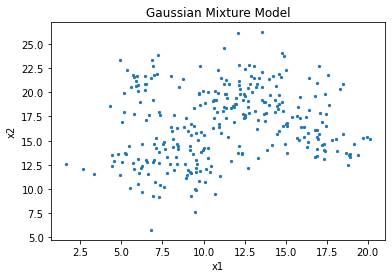

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal # input : x,\mu, \Sigma
from numpy.random import randn
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D

filename = 'datas.txt'
data = np.loadtxt(filename)

plt.scatter(data[:, 0], data[:, 1], s=5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Gaussian Mixture Model")
plt.show()

# 라이브러리 사용시 

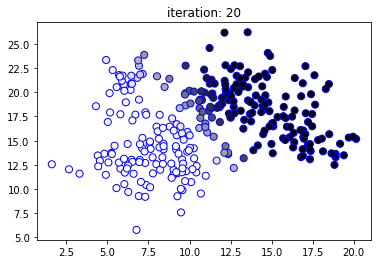

In [74]:
from sklearn.mixture import GaussianMixture
model = GaussianMixture(n_components=2, max_iter=20) 
model.fit(data)
pi = model.predict_proba(data)
plt.scatter(data[:, 0], data[:, 1], s=50, edgecolors="b", cmap=plt.cm.binary, c=pi[:,0])
plt.title("iteration: 20")
plt.show()

# Log Likelihood 정의 

log likelihood는 $$\ln p(x|\pi,\mu,\Sigma)$$ 

$$=\ln \{ \Pi^N_{n=1} p(x_n| \pi, \mu, \Sigma) \} = \Sigma^N_{n=1}\ln\{\Sigma^K_{k=1}\pi_k N(x_n|\mu_k, \Sigma_k)\}$$


이것을 함수화하기 위해 다음과 같이 데이터 X와 mixing coefficient인 $\pi$, 평균 $\mu$ 그리고 분산 $\Sigma$ 를 받는 함수를 만들어줍니다.

In [75]:
def logLikelihood(X, mixing_coeff, mu, cov):
    '''
    Log-likelihood function
    parameters:
    X: ndarray, shape of (N,D), N is number of samples, d is dimension of the data
    mu: ndarray, shape of (K,D), k is number of gaussian mixture model, id is dimension of the data
    cov: ndarray, shape of (K,D,D)
    mixing_coeff: ndarray, shape of (K,)
    output:
    scalar, loglikelihood
    '''
    N,D = X.shape
    K = mixing_coeff.size
    L= 0
    for k in range(K):
        L += mixing_coeff[k]*multivariate_normal.pdf(data, mean=mu[k,:], cov=cov[k,:,:])  # $\Sigma^N_{n=1}\ln\{\Sigma^K_{k=1}\pi_k N(X_n|\mu_k, \Sigma_k)\}$
    return sum(np.log(L))

# E step
EM 알고리즘을 시작하기 위해서는 처음의 random initialization이 필요합니다.
E step을 통해 모든 데이터와 Gaussian distribution에 대한 $\gamma(z_{nk})$를 계산합니다.
$$\gamma(z_{nk}) = p(z_{nk}=1 | x_n)$$
$$= \frac{\pi_k N(x_n|\mu_k,\Sigma_k)}{\Sigma^K_{j=1}\pi_jN(x_n|\mu_j,\Sigma_j)}$$

In [76]:
def Estep(X, mixing_coeff, mu, cov):

    N,D = X.shape
    K = mixing_coeff.size
    gamma = np.zeros([N,K])
    tmp = 0
    for k in range(K):
        tmp += mixing_coeff[k]*multivariate_normal.pdf(data, mean=mu[k,:], cov=cov[k,:,:])
    for k in range(K):
        gamma[:,k] = mixing_coeff[k]*multivariate_normal.pdf(data, mean=mu[k,:], cov=cov[k,:,:])/tmp
    return gamma

# M step

E step에서 구한 $\gamma$를 통해 $\mu, \Sigma, \pi$ 를 구합니다.

In [77]:
def Mstep(X, mu, cov, gamma):

    N,D = X.shape
    K = mu.shape[0]
    mu_new = np.zeros(mu.shape)
    cov_new = np.zeros(cov.shape)
    mixing_coeff_new = np.zeros(K)
    for k in range(K):
        Nk = np.sum(gamma[:,k])
        mu_new[k,:] = 1/Nk * np.sum(gamma[:,k][:, None]*X, axis=0)
        cov_new[k,:,:] = 1/Nk * gamma[:,k]*(X - mu_new[k,:]).T @ (X - mu_new[k,:])
        mixing_coeff_new[k] = Nk/N
    return mu_new, cov_new, mixing_coeff_new

decision boundary 그리기 


In [78]:
def _plot_gaussian(mean, covariance, zorder=0, color='blue'):
    """Plots the mean and 2-std ellipse of a given Gaussian"""
    plt.plot(mean[0], mean[1], ".", zorder=zorder, color=color)

    if covariance.ndim == 1:
        covariance = np.diag(covariance)

    radius = np.sqrt(5.991)
    eigvals, eigvecs = np.linalg.eig(covariance)
    axis = np.sqrt(eigvals) * radius
    slope = eigvecs[1][0] / eigvecs[1][1]
    angle = 180.0 * np.arctan(slope) / np.pi

    ax = plt.gca()
    ax.add_artist(Ellipse(
        mean, 2 * axis[0], 2 * axis[1], angle=angle, alpha=0.5,
        fill=False, linewidth=1, zorder=zorder, color=color
    ))

parameters를 초기화해줍니다.

In [79]:
# Initialize parameters                                             # 파라메타 초기화 random initialization
mu = np.array([[1,2],[20,25]])
cov = np.array([[[.5,0],[0,.5]],[[.2,.1],[.1,.2]]])
mixing_coeff = np.array([0.5, 0.5])

# Compute initial loglikelihood
llh = logLikelihood(data, mixing_coeff, mu, cov)
print('Initial loglikelihood: ',llh)

Initial loglikelihood:  -63156.62791841732


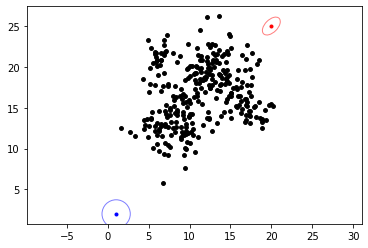

In [80]:
plt.scatter(data[:,0],data[:,1],s=15,color='black')
plt.axis('equal')
_plot_gaussian(mu[0,:], cov[0,:,:], zorder=0, color="blue")
_plot_gaussian(mu[1,:], cov[1,:,:], zorder=0, color='red')

Final loglikelihood:  -1619.116996453843


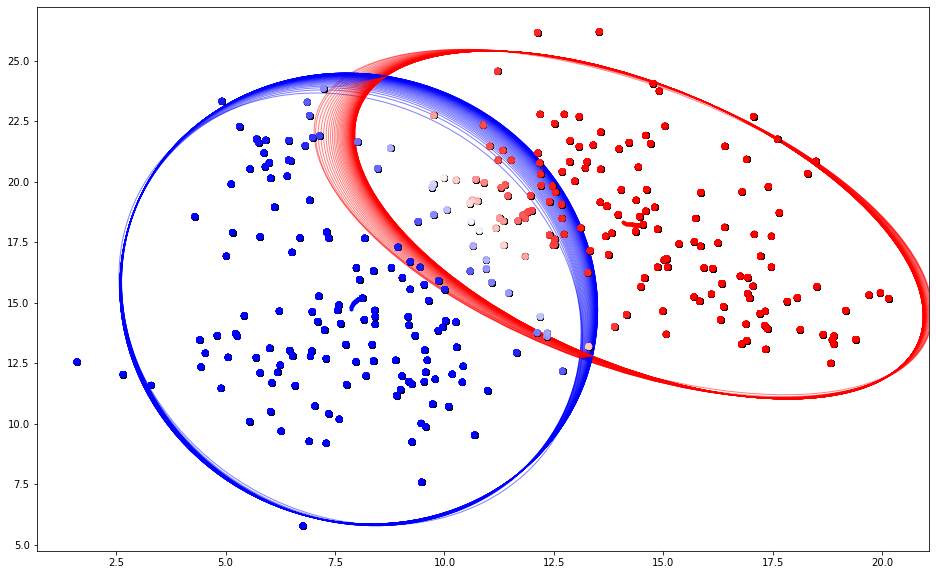

In [84]:
# plt.ion()
fig = plt.gcf()
fig.set_size_inches(16, 10)


count = 0
converge = False
while not converge:
    # E step
    gamma = Estep(data, mixing_coeff, mu, cov)
    # M step
    mu, cov, mixing_coeff = Mstep(data, mu, cov, gamma)
    # New loglikelihoodq
    llh_new = logLikelihood(data, mixing_coeff, mu, cov)
    # Update plot
    _plot_gaussian(mu[0,:], cov[0,:,:], zorder=0, color="blue")
    _plot_gaussian(mu[1,:], cov[1,:,:], zorder=0, color="red")
    plt.scatter(data[:,0],data[:,1],color='black')
    plt.scatter(data[:,0],data[:,1],c=gamma[:,1],cmap='bwr')
    count += 1
    plt.savefig('./saves/' + str(count) + '.jpg')

    if np.abs(llh_new-llh)>1e-5:
        llh = llh_new
    else:
        converge = True
print('Final loglikelihood: ',llh_new)


/tmp/ipykernel_129118/2959018270.py:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/tmp/ipykernel_129118/2959018270.py:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


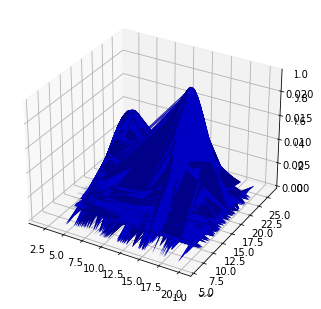

In [85]:
x3 = data[:,0]
y3 = data[:,1]
bottom = np.zeros(len(data))
 
dx = np.ones(len(data))
dy = np.ones(len(data))

X,Y = np.meshgrid(x3, y3)

fig = plt.figure()
ax = Axes3D(fig)
rv1 = multivariate_normal(mu[0,:],cov[0,:,:])
Z1 = rv1.pdf(np.dstack([X, Y]))

rv2 = multivariate_normal(mu[1,:],cov[1,:,:])
Z2 = rv2.pdf(np.dstack([X, Y]))
# Plot the surface.
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z1,color='blue')
ax.plot_surface(X, Y, Z2,color='blue')
plt.show()

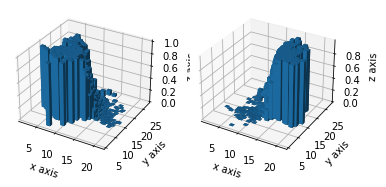

In [86]:
def draw_plot(ax, x3, y3, bottom, dx, dy, gamma):
    ax.bar3d(x3, y3, bottom, dx, dy, gamma)  
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
draw_plot(ax1, x3, y3, bottom, dx, dy, gamma[:,0])
draw_plot(ax2, x3, y3, bottom, dx, dy, gamma[:,1])
plt.show()